In [1]:
# Modified model to generate individuals by household

## Import Libraries and Datasets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [3]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose Variables and Preprocess

In [4]:
# Filter to desired variables (numeric then categorical)
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SCHL','PINCP','COW','SEX','MAR']]
pums_data_h = h_df[['SERIALNO','NP','VEH','HINCP']]
del p_df
del h_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)
pums_data = pums_data[['AGEP','JWMNP','SCHL','PINCP','HINCP','COW','SEX','MAR','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


In [5]:
CAT_IDX = 5
HH_IDX = [4,8,9]
LEN_PERS = pums_data_p.shape[1] - 1
LEN_HH = pums_data_h.shape[1] - 1
VAR_DIM = pums_data.shape[1] #Length of all variables before OHE
VAR_NAMES = pums_data.columns #Names of all variables before OHE

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [8, 2, 5, 18, 7]


In [6]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Add columns for original household variables; these will be fed to decoder but not encoder
model_data_df = pd.concat([model_data_df, pums_data.iloc[:,HH_IDX]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP,JWMNP,SCHL,PINCP,HINCP,COW__1.0,COW__2.0,COW__3.0,COW__4.0,COW__5.0,...,VEH__0.0,VEH__1.0,VEH__2.0,VEH__3.0,VEH__4.0,VEH__5.0,VEH__6.0,HINCP,NP,VEH
4,52,70.0,21.0,160000.0,210500.0,1,0,0,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
5,51,20.0,21.0,50000.0,210500.0,0,0,1,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
7,59,30.0,19.0,26710.0,50310.0,0,0,1,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
8,56,15.0,16.0,23600.0,50310.0,1,0,0,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
9,40,5.0,5.0,10000.0,31200.0,1,0,0,0,0,...,1,0,0,0,0,0,0,31200.0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,50.0,21.0,55000.0,55000.0,1,0,0,0,0,...,0,0,1,0,0,0,0,55000.0,3,2.0
356010,33,65.0,18.0,90000.0,102000.0,1,0,0,0,0,...,0,0,1,0,0,0,0,102000.0,4,2.0
356013,48,60.0,18.0,48400.0,106400.0,1,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0
356014,49,30.0,19.0,49000.0,106400.0,1,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0


In [7]:
# Standardize the input data from -1 to 1 for numerical variables
scaler_pers = skpre.StandardScaler()
scaler_hh = skpre.StandardScaler()
model_data = model_data_df.values
model_data[:,:CAT_IDX] = scaler_pers.fit_transform(model_data[:,:CAT_IDX])
model_data[:,MANIFEST_DIM:] = scaler_hh.fit_transform(model_data[:,MANIFEST_DIM:])

# Remove rows with numerical outliers (3 < standard deviations)
print(f"Dataset n={len(model_data)} pre-numerical-outliers")
outlier_row_indices = np.where(np.any(model_data[:,:CAT_IDX] > 3, axis=1))
model_data = np.delete(model_data, (outlier_row_indices), axis=0)
model_data_df = model_data_df.drop(model_data_df.index[outlier_row_indices])
print(f"Dataset n={len(model_data)} post-numerical-outliers")

# Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

Dataset n=150203 pre-numerical-outliers
Dataset n=143451 post-numerical-outliers


## Set Parameters and Define Model

### TODO:

###### Build up fundamental model:
-Test speeds vs traditional methods  
-Energy distance test for distributions  
-Check distributions of variables within households, compare to naive method w/borysov model somehow  
-Test making epsilon the same distribution as the actual posteriors in the model

###### Differentiate from the GenSynth paper:
-Travel diaries  
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN?  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [8]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 5
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [9]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

### Person Model

In [10]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          4600        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            505         dense_1[0][0]                    
____________________________________________________________________________________________

In [11]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM + LEN_HH,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          900         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 5)            505         dense_3[0][0]                    
____________________________________________________________________________________________

In [12]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    reconstruction_num = reconstruction[0]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [13]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data[:,:MANIFEST_DIM])
            decoder_input = tf.concat([z, data[:,MANIFEST_DIM:]], axis=1)
            reconstruction = decoder(decoder_input)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs[:,:MANIFEST_DIM])
        decoder_input = tf.concat([z, inputs[:,MANIFEST_DIM:]], axis=1)
        reconstruction = self.decoder(decoder_input)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [14]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE) #add callbacks=[callback] if debugging needed

Epoch 1/10
2018/2018 [==============================] - 5s 2ms/step - total_loss: 2.6984 - reconstruction_loss: 1.1897 - reconstruction_loss_num: 0.4339 - reconstruction_loss_cat: 0.7558 - kl_loss: 0.5967
Epoch 2/10
2018/2018 [==============================] - 5s 2ms/step - total_loss: 1.0924 - reconstruction_loss: 0.4952 - reconstruction_loss_num: 0.3247 - reconstruction_loss_cat: 0.1704 - kl_loss: 0.5549
Epoch 3/10
2018/2018 [==============================] - 5s 2ms/step - total_loss: 0.9607 - reconstruction_loss: 0.3685 - reconstruction_loss_num: 0.2539 - reconstruction_loss_cat: 0.1147 - kl_loss: 0.5706
Epoch 4/10
2018/2018 [==============================] - 5s 2ms/step - total_loss: 0.8937 - reconstruction_loss: 0.3109 - reconstruction_loss_num: 0.2235 - reconstruction_loss_cat: 0.0874 - kl_loss: 0.5755
Epoch 5/10
2018/2018 [==============================] - 5s 2ms/step - total_loss: 0.8651 - reconstruction_loss: 0.2841 - reconstruction_loss_num: 0.2093 - reconstruction_loss_cat: 

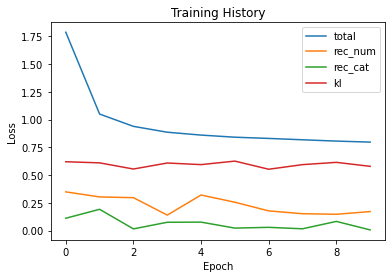

In [15]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

Latent Variable: 0
Mean: 0.0063012694008648396
Variance: 1.1806796789169312



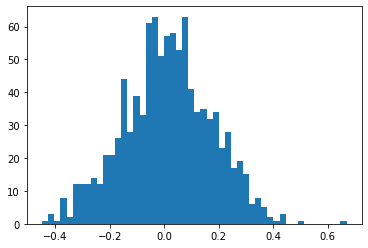

Latent Variable: 1
Mean: -0.024203510954976082
Variance: 1.1848273277282715



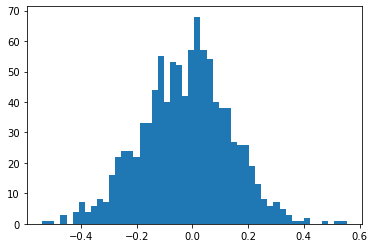

Latent Variable: 2
Mean: 0.03631637245416641
Variance: 1.4173864126205444



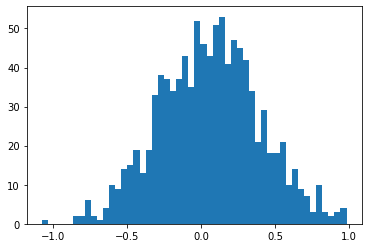

Latent Variable: 3
Mean: 0.0036278674378991127
Variance: 1.7127658128738403



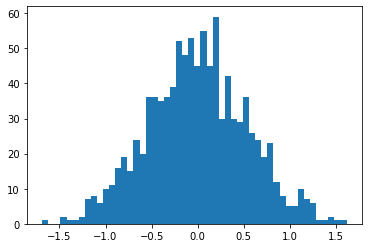

Latent Variable: 4
Mean: -0.055624064058065414
Variance: 1.171778917312622



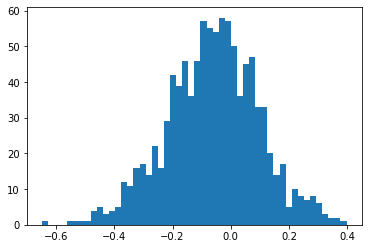

In [16]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Record the posterior trained distributions for z
latent_means = []
latent_vars = []

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    latent_means.append(avg_mean)
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    latent_vars.append(avg_var)
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_var)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [17]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.18042722344398499
Categorical Variable Loss: 0.05741221830248833


In [18]:
if len(CAT_LENGTHS) > 0:
    # Transform numeric results back to real variable values
    results_num = scaler_pers.inverse_transform(results[0])
    results_df = pd.DataFrame(results_num)

    # Transform categorical results back to real variable values
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result
else:
    results_num = scaler_pers.inverse_transform(results)
    results_df = pd.DataFrame(results_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES

In [19]:
# Transform numeric test data back to real variable values
test_data_num = scaler_pers.inverse_transform(test_data[:,:CAT_IDX])
test_data_df = pd.DataFrame(test_data_num)

if len(CAT_LENGTHS) > 0:
    # Transform categorical test data back to real variable values
    current = CAT_IDX
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x

# Add back original variables names to the test data
test_data_df.columns = VAR_NAMES

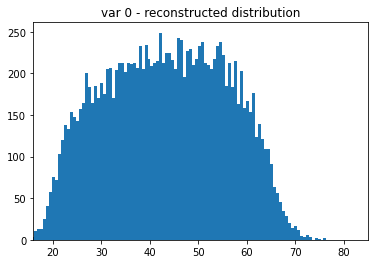

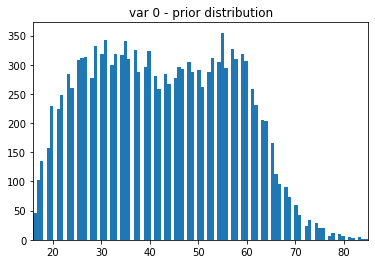

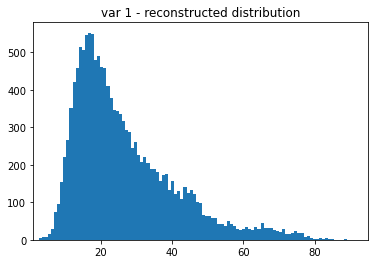

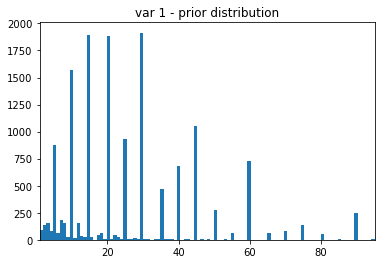

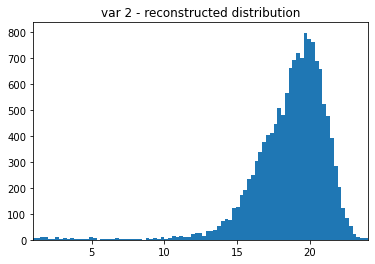

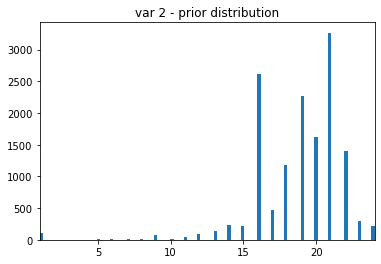

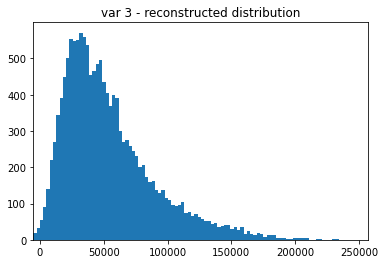

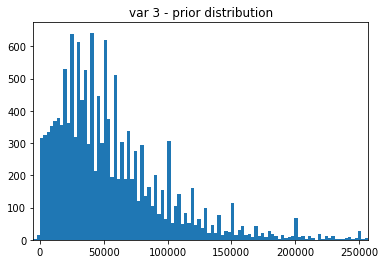

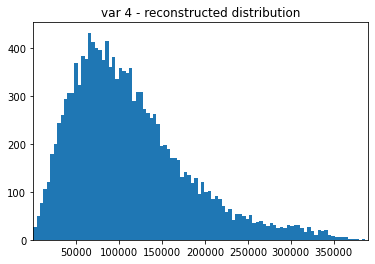

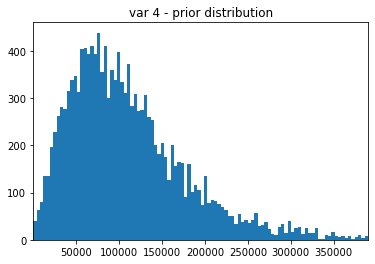

In [20]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

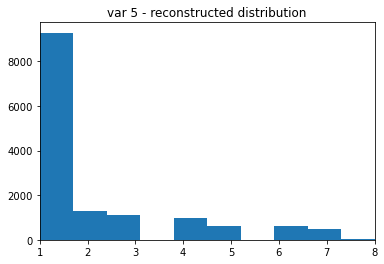

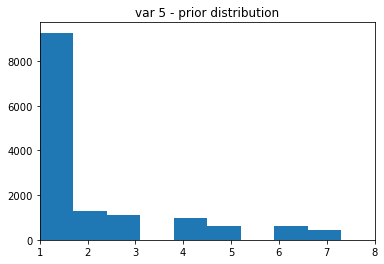

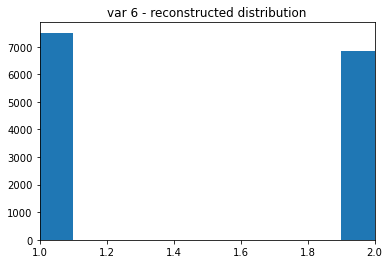

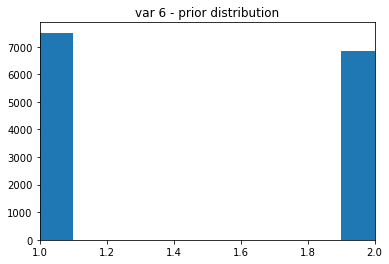

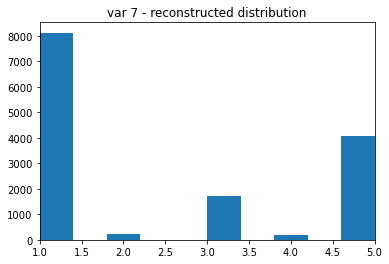

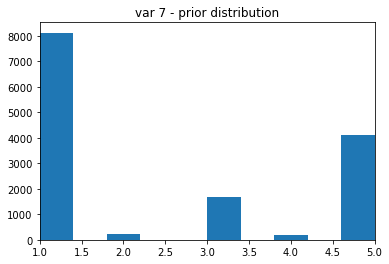

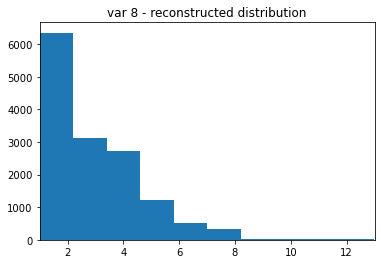

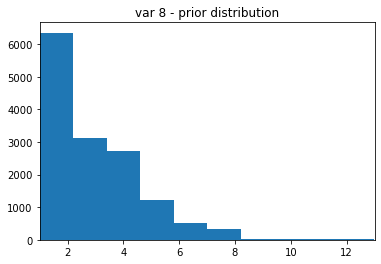

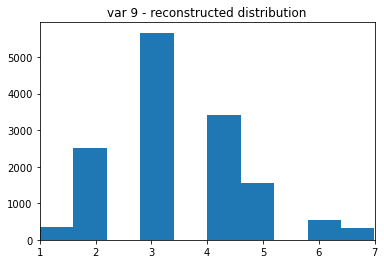

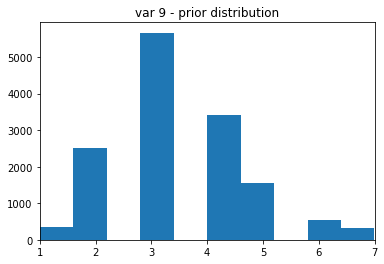

In [21]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

## Generating Synthetic Population

In [22]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')

# How many synthetic households to fill
POP_SIZE = 300000

# How many variables represent each household
HH_DIM = 3

# Create new column for copy of hh sizes and scale household input variables
synth_hh_df = synth_hh_df.sample(POP_SIZE)
sizes = synth_hh_df[['NP']]
synth_hh_df = pd.concat([synth_hh_df, sizes], axis=1)
synth_hh_df.iloc[:,:HH_DIM] = scaler_hh.fit_transform(synth_hh_df.iloc[:,:HH_DIM])
synth_hh_df.columns = ['HINCP','NP','VEH','SIZE']

# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['SIZE']))
z = synth_hh_df[['HINCP','NP','VEH']].values

# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(len(z), LATENT_DIM))
inputs = np.concatenate((epsilon, z), axis=-1)

In [23]:
start_time = time.time()

In [24]:
# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict(inputs)

In [25]:
print(f"--- {time.time() - start_time} seconds ---")

--- 21.8698832988739 seconds ---


In [26]:
# Transform numeric results back to real variable values
results_num = scaler_pers.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

# Add back household ids to the results
results_df['HH_ID'] = synth_hh_df['HH_ID'].values
results_df

,AGEP,JWMNP,SCHL,PINCP,HINCP,COW,SEX,MAR,NP,VEH,HH_ID
0,40.310871,25.471462,20.934402,57910.285156,114526.492188,6,1,1,5,3,706612
1,34.430473,43.109669,18.373312,48985.835938,128515.953125,1,2,3,5,2,706612
2,30.233763,72.228577,19.794851,44603.871094,123163.015625,1,1,5,5,3,706612
3,42.111595,0.596074,20.503004,18847.335938,145537.968750,3,2,1,5,3,706612
4,34.829109,81.753479,19.611160,57386.253906,124212.132812,1,1,5,5,3,706612
...,...,...,...,...,...,...,...,...,...,...,...
835048,41.916084,27.419426,20.967527,117344.187500,283156.593750,5,1,1,6,4,446636
835049,45.779999,26.015276,22.810385,127388.687500,285415.062500,3,1,1,6,4,446636
835050,28.236729,14.512589,20.669130,63738.171875,247559.265625,1,2,5,6,4,446636
835051,41.757793,44.533226,18.007763,99494.187500,279570.031250,6,1,1,6,4,446636


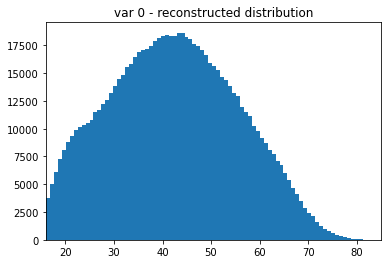

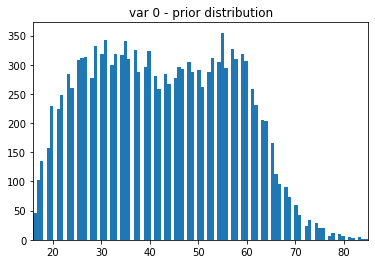

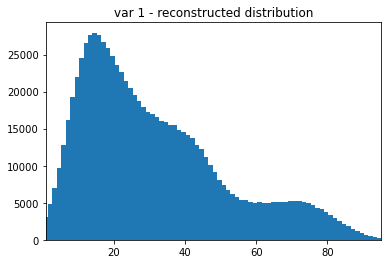

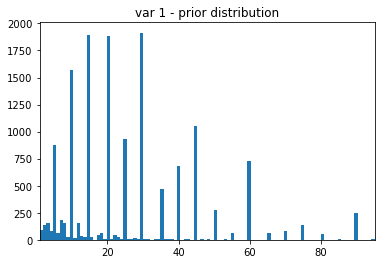

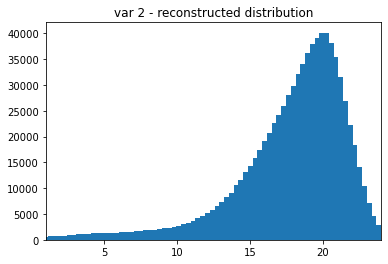

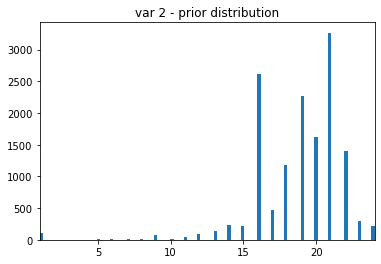

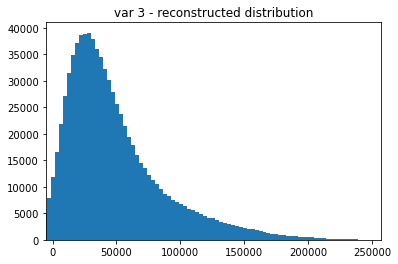

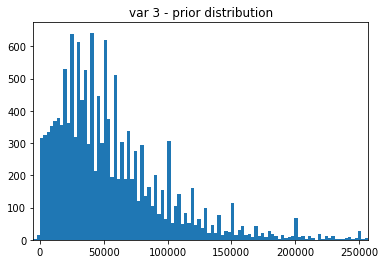

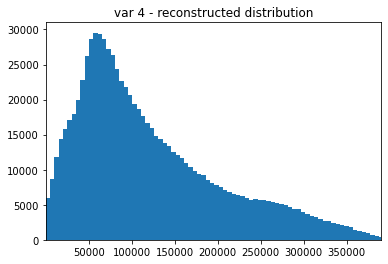

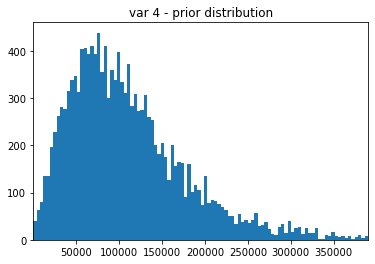

In [27]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

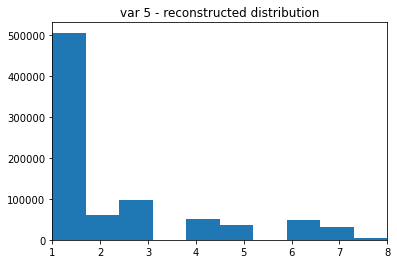

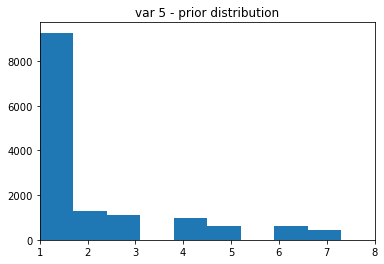

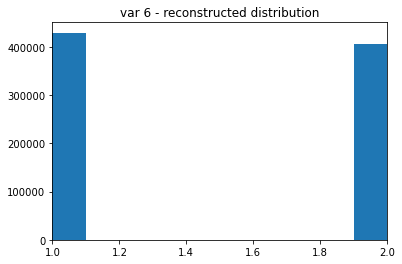

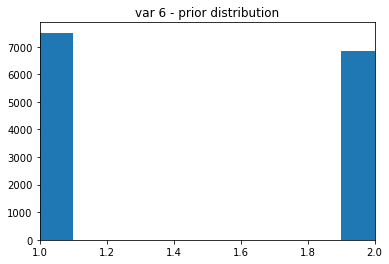

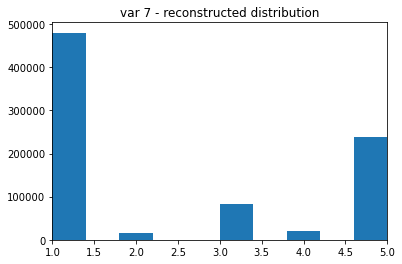

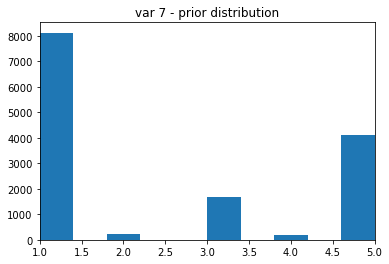

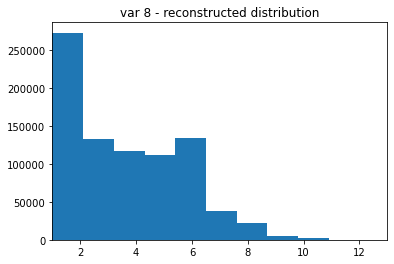

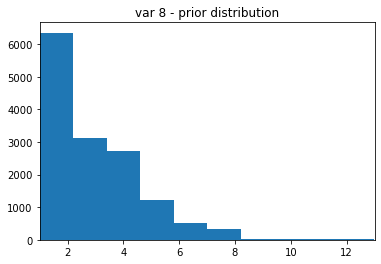

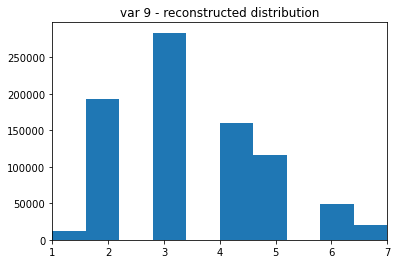

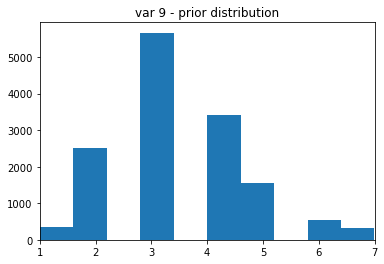

In [28]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()